In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.fill import fillnodata

import pymannkendall as mk
import scipy.ndimage as ndimage

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import stats as st

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

import signal
import time

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-03-10 11:36:24 Configured OSMnx 1.1.2
2023-03-10 11:36:24 HTTP response caching is on


In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Download data

### Municipality GeoDataFrame

(18, 6)


<AxesSubplot: >

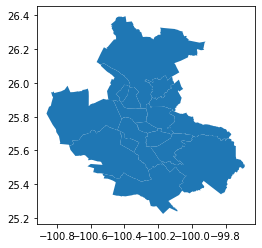

In [3]:
city = 'Monterrey'
query = f"SELECT * FROM metropolis.metro_gdf WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

(1545, 2)


<AxesSubplot: >

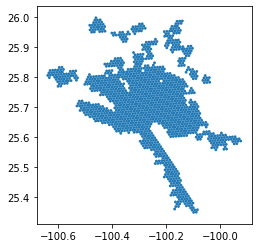

In [4]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

In [5]:
hex_ageb.head(2)

,hex_id_8,geometry
0,8848a23881fffff,"POLYGON ((-100.38026 25.93877, -100.38069 25.9..."
1,8848a23883fffff,"POLYGON ((-100.38588 25.94625, -100.38631 25.9..."


Create hexagons for area with population at different resolutions

In [6]:
hex_gdf = hex_ageb.copy()
hex_gdf.rename(columns={'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

for r in range(9,12):
    
    hex_tmp = aup.create_hexgrid(hex_ageb, r)
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    
    hex_gdf = pd.concat([hex_gdf, hex_tmp], 
        ignore_index = True, axis = 0)
    
    del hex_tmp

In [7]:
print(hex_gdf.shape)
hex_gdf.head(2)

(618000, 3)


,hex_id,geometry,res
0,8848a23881fffff,"POLYGON ((-100.38026 25.93877, -100.38069 25.9...",8
1,8848a23883fffff,"POLYGON ((-100.38588 25.94625, -100.38631 25.9...",8


## Access raster data

### Create boundaries for imagery download

In [8]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_gdf.loc[hex_gdf.res==8].to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

#### Generate polygon dictionary

In [9]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

### Define time period for imagery

Since the api is limited to a max of 100 images, dates are divided in periods of 3 months.

In [10]:
time_of_interest = ["2020-01-01/2020-03-31","2020-04-01/2020-06-30",
                    "2020-07-01/2020-09-30","2020-10-01/2020-12-31",
                    "2021-01-01/2021-03-31","2021-04-01/2021-06-30",
                    "2021-07-01/2021-09-30","2021-10-01/2021-12-31",
                    "2022-01-01/2022-03-31","2022-04-01/2022-06-30",
                    "2022-07-01/2022-09-30","2022-10-01/2022-12-31",
                   ]

### Identify imagery

This section identifies satellite imagery that meets the requeirments for the Satellite (sentinel-2-l2a), area_of_interest, time_of_interest and limit for cloud cover (10%).

In [11]:
def gather_items(time_of_interest):
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    items = []

    for t in time_of_interest:
        search = catalog.search(
            collections=["sentinel-2-l2a"],
            intersects=area_of_interest,
            datetime=t,
            query={"eo:cloud_cover": {"lt": 10}},
        )

        # Check how many items were returned
        items.extend(list(search.get_items()))
    return items
items = gather_items(time_of_interest)
print(f"Returned {len(items)} Items")

Returned 158 Items


## Raster data gathering and filter

### Gather links for imagery bands

Identify download links for Near Infrared (nir) and SWIR bands for each date that meets the requierments.

In [12]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

Bands to analyze

In [13]:
band_name_list = ['red','nir']

In [14]:
def link_dict(band_name_list, items):
    
    assets_hrefs = {}

    for i in items:
        if i.datetime.date() in list(assets_hrefs.keys()):
            for b in band_name_list:
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
        else:
            assets_hrefs[i.datetime.date()] = {}
            for b in band_name_list:
                assets_hrefs[i.datetime.date()].update({b:[]})
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
                
    return assets_hrefs

In [15]:
assets_hrefs = link_dict(band_name_list, items)

Remove dates without insuficcient data

In [16]:
def filter_links(assets_hrefs, band_name_list):
    max_links_len = st.mode(np.array([len(x[band_name_list[0]]) for x in list(assets_hrefs.values())]))[0][0]
    
    # iterate and remove dates without sufficient data
    for k_date in list(assets_hrefs.keys()):
        # gather data from first band in dictionary - the max value should be the same in all bands
        k_band = list(assets_hrefs[k_date].keys())[0]
        # compare len of that band to max
        if len(assets_hrefs[k_date][k_band]) != max_links_len:
            # if len is less it indicates that is missing data
            # remove date with missing data
            assets_hrefs.pop(k_date)
    
    return assets_hrefs, max_links_len

In [17]:
assets_hrefs, m = filter_links(assets_hrefs, band_name_list)

Filter data by month

In [18]:
def df_date_links(assets_hrefs, start_date, periods):
    # dictionary to dataframe
    df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
    df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
    df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
    df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
    
    df_dates_filtered = pd.DataFrame()
    
    # keep only one data point by month
    for y in df_dates['year'].unique():
        for m in df_dates.loc[df_dates['year']==y,'month'].unique():
            df_dates_filtered = pd.concat([df_dates_filtered,
                                         df_dates.loc[(df_dates['year']==y)&
                                                      (df_dates['month']==m)].sample(1)],
                                          ignore_index=True)
    
    # create full range time dataframe
    df_tmp_dates = pd.DataFrame() # temporary date dataframe
    df_tmp_dates['date'] = pd.date_range(start = start_date,   
                               periods = periods,   # there are 30 periods because range from satelite img goes from 01-01-2020 - 30-06-2022
                               freq = "M") # create date range
    # extract year and month
    df_tmp_dates['year'] = df_tmp_dates.apply(lambda row: row['date'].year, axis=1)
    df_tmp_dates['month'] = df_tmp_dates.apply(lambda row: row['date'].month, axis=1)

    # remove date column for merge
    df_tmp_dates.drop(columns=['date'], inplace=True)

    df_complete_dates = df_tmp_dates.merge(df_dates_filtered, left_on=['year','month'],
                                          right_on=['year','month'], how='left')

    # remove date 
    df_complete_dates.drop(columns='date', inplace=True)
    df_complete_dates.sort_values(by=['year','month'], inplace=True)
    
    idx = df_complete_dates.red.isna()
    df_complete_dates['data_id'] = 0
    df_complete_dates.loc[~idx,'data_id'] = 1
    
    df_complete_dates.drop(columns=['red','nir'], inplace=True)
    
    missing_months = len(df_complete_dates.loc[df_complete_dates.data_id==0])
    #missing_months = df_complete_dates.nir.isna().sum()
    
    return df_complete_dates, missing_months

In [19]:
df_len, missing_months = df_date_links(assets_hrefs, "2020-01-01", 36)

In [20]:
print(df_len.shape)
df_len.head(4)

(36, 3)


,year,month,data_id
0,2020,1,1
1,2020,2,0
2,2020,3,1
3,2020,4,1


## Create NDMI files

In [21]:
def mosaic_raster(raster_asset_list, tmp_dir='tmp/', upscale=False):
    src_files_to_mosaic = []

    for assets in raster_asset_list:
        src = rasterio.open(assets)
        src_files_to_mosaic.append(src)
        
    mosaic, out_trans = merge(src_files_to_mosaic) # mosaic raster
    
    meta = src.meta
    
    if upscale:
        # save raster
        out_meta = src.meta

        out_meta.update({"driver": "GTiff",
                         "dtype": 'float32',
                         "height": mosaic.shape[1],
                         "width": mosaic.shape[2],
                         "transform": out_trans})
        # write raster
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "w", **out_meta) as dest:
            dest.write(mosaic)

            dest.close()
        # read and upscale
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "r") as ds:

            upscale_factor = 1/2

            mosaic = ds.read(
                        out_shape=(
                            ds.count,
                            int(ds.height * upscale_factor),
                            int(ds.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

        ds.close()
    src.close()
    
    return mosaic, out_trans, meta

In [22]:
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

### test adding time_limit

In [23]:
from func_timeout import func_timeout, FunctionTimedOut

In [33]:
index_analysis = 'ndvi'
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'
time_range = 36
time_exc_limit = 600

df_len['raster_row'] = np.nan
df_len['raster_col'] = np.nan

aup.log('\n Starting raster analysis')

# check if file exists, for example in case of code crash
df_file_dir = tmp_dir+index_analysis+f'_{city}_dataframe.csv'
if os.path.exists(df_file_dir) == False: # Or folder, will return true or false
    df_len.to_csv(df_file_dir)

for i in tqdm(range(len(df_len)), position=0, leave=True):
    
    df_raster = pd.read_csv(df_file_dir, index_col=False)

    
    checker = 0

    if df_raster.iloc[i].data_id==0:
        continue
        
    # gather month and year from df to save ndmi
    month_ = df_raster.loc[df_raster.index==i].month.values[0]
    year_ = df_raster.loc[df_raster.index==i].year.values[0]
    
    if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
        continue
    
    aup.log(f'\n Starting new analysis for {month_}/{year_}')
    
    # gather links for raster images
    sample_date = datetime(year_, month_, 1)
    first_day = sample_date + relativedelta(day=1)
    last_day = sample_date + relativedelta(day=31)
    
    time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                        f"-{month_:02d}-{last_day.day:02d}"]
    
    items = gather_items(time_of_interest)
    
    assets_hrefs = link_dict(band_name_list,items)
    
    df_links = pd.DataFrame.from_dict(assets_hrefs, 
                                      orient='Index').reset_index().rename(columns={'index':'date'})
    
    # mosaic raster
    def mosaic_process(red_links, nir_links):
        mosaic_red, _,_ = aup.mosaic_raster(red_links)
        aup.log('Finished processing red')
        mosaic_nir, out_trans_nir, out_meta = aup.mosaic_raster(nir_links)
        aup.log('Finished processing nir')
        return mosaic_red, mosaic_nir, out_trans_nir,out_meta
    
    iter_count = 1
    
    while iter_count <= 5:

        for data_link in range(len(df_links)):
            aup.log(f'Mosaic date {df_links.iloc[data_link].date.day}'+
                        f'/{df_links.iloc[data_link].date.month}'+
                        f'/{df_links.iloc[data_link].date.year} - iteration:{iter_count}')
            try:
                red_links = df_links.iloc[data_link].red
                nir_links = df_links.iloc[data_link].nir

                mosaic_red, mosaic_nir, out_trans_nir,out_meta = func_timeout(time_exc_limit, mosaic_process,
                                                                              args=(red_links,nir_links))          
                checker = 1
                iter_count = 6
                break
            except:
                aup.log(f'Error in iteration {iter_count}')
                continue
        iter_count = iter_count + 1
            
    if checker==0:
        df_raster.loc[df_raster.index==i,'data_id']=0
        continue

    mosaic_red = mosaic_red.astype('float32')
    mosaic_nir = mosaic_nir.astype('float32')
    aup.log('Transformed red and nir to float')
    aup.log(f'array datatype: {mosaic_red.dtype}')

    ndvi = (mosaic_nir-mosaic_red)/(mosaic_nir+mosaic_red)
    aup.log('Calculated ndvi')

    out_meta.update({"driver": "GTiff",
                "dtype": 'float32',
                "height": ndvi.shape[1],
                "width": ndvi.shape[2],
                "transform": out_trans_nir})

    aup.log('Starting save')

    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif", "w", **out_meta) as dest:
        dest.write(ndvi)

        dest.close()

    aup.log('Finished saving complete dataset')
    
    aup.log('Starting crop')
    
    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif") as src:
        gdf_bb = gdf_bb.to_crs(src.crs)
        shapes = [gdf_bb.iloc[feature].geometry for feature in range(len(gdf_bb))]
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                             "dtype": 'float32',
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})
        src.close()
    aup.log('Finished croping')
    
    df_raster.loc[((df_raster['year']==year_)&
              (df_raster['month']==month_)),'raster_row'] = out_image.shape[1]
    df_raster.loc[((df_len['year']==year_)&
              (df_raster['month']==month_)),'raster_col'] = out_image.shape[2]
    
    aup.log('Starting interpolation to fill na')
    raster_fill = fillnodata(out_image, mask=~np.isnan(out_image),
                         max_search_distance=10, smoothing_iterations=0)
    aup.log('Finished interpolation to fill na')
    
    aup.log('Starting to save croped raster')
        
    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
        dest.write(raster_fill)

        dest.close()
    aup.log('Finished saving croped raster')
    
    df_raster.to_csv(df_file_dir)
    
    del out_image
    del mosaic_red
    del mosaic_nir
    del ndvi

df_len = pd.read_csv(df_file_dir)[['year','month','data_id','raster_row','raster_col']]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 131.75it/s]


In [30]:
index_analysis = 'ndvi'
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'
time_range = 36

df_len['raster_row'] = np.nan
df_len['raster_col'] = np.nan

aup.log('\n Starting raster analysis')

#df_len.to_csv(tmp_dir+index_analysis+'_dataframe.csv')

for i in tqdm(range(len(df_len)), position=0, leave=True):
    
    df_raster = pd.read_csv(tmp_dir+index_analysis+'_dataframe.csv', index_col=False)

    
    checker = 0

    if df_raster.iloc[i].data_id==0:
        continue
        
    # gather month and year from df to save ndmi
    month_ = df_raster.loc[df_raster.index==i].month.values[0]
    year_ = df_raster.loc[df_raster.index==i].year.values[0]
    
    if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
        continue
    
    aup.log(f'\n Starting new analysis for {month_}/{year_}')
    
    # gather links for raster images
    sample_date = datetime(year_, month_, 1)
    first_day = sample_date + relativedelta(day=1)
    last_day = sample_date + relativedelta(day=31)
    
    time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                        f"-{month_:02d}-{last_day.day:02d}"]
    
    items = gather_items(time_of_interest)
    
    assets_hrefs = link_dict(band_name_list,items)
    
    df_links = pd.DataFrame.from_dict(assets_hrefs, 
                                      orient='Index').reset_index().rename(columns={'index':'date'})
    
    # mosaic raster
    def mosaic_process(red_links, nir_links):
        mosaic_red, _,_ = aup.mosaic_raster(red_links)
        aup.log('Finished processing red')
        mosaic_nir, out_trans_nir, out_meta = aup.mosaic_raster(nir_links)
        aup.log('Finished processing nir')
        return mosaic_red, mosaic_nir, out_trans_nir,out_meta

    for data_link in range(len(df_links)):
        try:
            aup.log(f'Mosaic date {df_links.iloc[data_link].date.day}'+
                    f'/{df_links.iloc[data_link].date.month}'+
                    f'/{df_links.iloc[data_link].date.year}')
            mosaic_red, mosaic_nir, out_trans_nir,out_meta = mosaic_process(
                df_links.iloc[data_link].red,
                          df_links.iloc[data_link].nir)
            checker = 1
            break
        except:
            continue
            
    if checker==0:
        df_raster.iloc[i].data_id=0
        continue

    mosaic_red = mosaic_red.astype('float32')
    mosaic_nir = mosaic_nir.astype('float32')
    aup.log('Transformed red and nir to float')
    aup.log(f'array datatype: {mosaic_red.dtype}')

    ndvi = (mosaic_nir-mosaic_red)/(mosaic_nir+mosaic_red)
    aup.log('Calculated ndvi')

    out_meta.update({"driver": "GTiff",
                "dtype": 'float32',
                "height": ndvi.shape[1],
                "width": ndvi.shape[2],
                "transform": out_trans_nir})

    aup.log('Starting save')

    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif", "w", **out_meta) as dest:
        dest.write(ndvi)

        dest.close()

    aup.log('Finished saving complete dataset')
    
    aup.log('Starting crop')
    
    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif") as src:
        gdf_bb = gdf_bb.to_crs(src.crs)
        shapes = [gdf_bb.iloc[feature].geometry for feature in range(len(gdf_bb))]
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                             "dtype": 'float32',
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})
        src.close()
    aup.log('Finished croping')
    
    df_raster.loc[((df_raster['year']==year_)&
              (df_raster['month']==month_)),'raster_row'] = out_image.shape[1]
    df_raster.loc[((df_len['year']==year_)&
              (df_raster['month']==month_)),'raster_col'] = out_image.shape[2]
    
    aup.log('Starting interpolation to fill na')
    raster_fill = fillnodata(out_image, mask=~np.isnan(out_image),
                         max_search_distance=10, smoothing_iterations=0)
    aup.log('Finished interpolation to fill na')
    
    aup.log('Starting to save croped raster')
        
    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
        dest.write(raster_fill)

        dest.close()
    aup.log('Finished saving croped raster')
    
    df_raster.to_csv(tmp_dir+index_analysis+'_dataframe.csv')
    
    del out_image
    del mosaic_red
    del mosaic_nir
    del ndvi

df_len = df_raster.copy()

  0%|                                                                                                                                                      | 0/36 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/tmp_ndvi/ndvi_dataframe.csv'

## Raster interpolation

In [34]:
row_mode = df_len.raster_row.mode().values[0]
col_mode = df_len.raster_col.mode().values[0]
df_len.loc[((df_len.raster_row < row_mode)|
          (df_len.raster_col < col_mode)|
           (df_len.raster_col.isna())),'data_id'] = 0 

In [35]:
df_len

,year,month,data_id,raster_row,raster_col
0,2020,1,1,7502.0,7470.0
1,2020,2,0,NaN,NaN
2,2020,3,1,7502.0,7470.0
3,2020,4,1,7502.0,7470.0
4,2020,5,1,7502.0,7470.0
5,2020,6,1,7502.0,7470.0
6,2020,7,1,7502.0,7470.0
7,2020,8,0,7502.0,874.0
8,2020,9,1,7502.0,7470.0
9,2020,10,1,7502.0,7470.0


In [36]:
inter_dir = tmp_dir

for row in range(len(df_len)):
    
    if df_len.iloc[row].data_id == 0:
        start = row - 1
        
        try:
            finish = df_len.iloc[row:,:].data_id.ne(0).idxmax()
        except:
            finish = len(df_len)
            
        aup.log(f'Start:{start} - Finish:{finish}')
                
        df_subset = df_len.iloc[start:finish+1]
        if df_subset.loc[df_subset.index==start].data_id.values[0] == 0:
            
            aup.log('Enterning missing data case 1')
            
            month_ = df_subset.loc[df_subset.index==finish].month.values[0]
            year_ = df_subset.loc[df_subset.index==finish].year.values[0]
            raster_file = rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif")
            meta = raster_file.meta
            raster_last = raster_file.read()
            
            aup.log('Read last raster data')
            
            cont = 0
            raster_list = []
            while df_subset.iloc[cont].data_id == 0:
                month_ = df_subset.iloc[cont].month
                year_ = df_subset.iloc[cont].year
                with rasterio.open(f"{inter_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **meta) as dest:
                    dest.write(raster_last)

                    dest.close()
                    
                    aup.log('Finished creating raster')
                
                cont += 1
            
        elif df_subset.loc[df_subset.index==finish].data_id.values[0] == 0:
            
            aup.log('Enterning missing data case 2')
            
            month_ = df_subset.loc[df_subset.index==start].month.values[0]
            year_ = df_subset.loc[df_subset.index==start].year.values[0]
            raster_file = rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif")
            meta = raster_file.meta
            raster_first = raster_file.read()
            
            aup.log('Read first raster data')
            
            cont = 1
            raster_list = []
            while df_subset.iloc[cont]:
                month_ = df_subset.iloc[cont].month
                year_ = df_subset.iloc[cont].year
                with rasterio.open(f"{inter_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **meta) as dest:
                    dest.write(raster_first)

                    dest.close()
                    
                    aup.log('Finished creating raster')
                
                cont += 1
            
        else:
            
            aup.log('Enterning missing data case 3')
            
            month_ = df_subset.loc[df_subset.index==start].month.values[0]
            year_ = df_subset.loc[df_subset.index==start].year.values[0]
            raster_file = rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif")
            raster_first = raster_file.read()
            
            month_ = df_subset.loc[df_subset.index==finish].month.values[0]
            year_ = df_subset.loc[df_subset.index==finish].year.values[0]
            raster_file = rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif")
            meta = raster_file.meta
            raster_last = raster_file.read()
            
            missing_len = len(df_subset.loc[df_subset.data_id==0])
            slope = 1 / (missing_len + 1)
            slope_increment = slope
            
            cont = 1
            
            aup.log(f'Preparing data for interpolation with slope {slope}')
            
            # rejoin arr1, arr2 into a single array of shape (2, 10, 10)
            arr = np.r_['0,3', raster_first, raster_last]
            # define the grid coordinates where you want to interpolate
            dim_row = raster_first.shape[1]
            dim_col = raster_first.shape[2]

            X, Y = np.meshgrid(np.arange(dim_row), np.arange(dim_col))
            
            while round(slope,4) < 1:
                
                aup.log(f'Starting interpolation for iteration {cont} with position {slope}')
                # switch order of col and row
                coordinates = np.ones((dim_col, dim_row))*slope, X, Y
                
                inter_raster = ndimage.map_coordinates(arr, coordinates, order=1).T
                inter_raster = inter_raster.reshape((1,inter_raster.shape[0],inter_raster.shape[1]))
                
                month_ = int(df_subset.iloc[cont].month)
                year_ = int(df_subset.iloc[cont].year)
                with rasterio.open(f"{inter_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **meta) as dest:
                    dest.write(inter_raster)

                    dest.close()
                    
                    aup.log(f'Finished creating raster')
                    
                    df_len.loc[df_len.index==start+cont,'data_id'] = 1
                
                cont += 1
                slope = slope + slope_increment

In [37]:
df_len.to_csv(df_file_dir)

In [38]:
df_len

,year,month,data_id,raster_row,raster_col
0,2020,1,1,7502.0,7470.0
1,2020,2,1,NaN,NaN
2,2020,3,1,7502.0,7470.0
3,2020,4,1,7502.0,7470.0
4,2020,5,1,7502.0,7470.0
5,2020,6,1,7502.0,7470.0
6,2020,7,1,7502.0,7470.0
7,2020,8,1,7502.0,874.0
8,2020,9,1,7502.0,7470.0
9,2020,10,1,7502.0,7470.0


## NDMI to Hexagon

In [39]:
raster_file = ''

In [40]:
def clean_mask(geom, dataset=raster_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = rasterio.mask.mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

In [41]:
def raster_to_hex(hex_gdf, df_len, r, index_analysis, raster_dir):
    # create empty geodataframe to save ndmi by date
    hex_raster = gpd.GeoDataFrame()

    for d in tqdm(range(len(df_len)),position=0,leave=True):

        month_ = df_len.loc[df_len.index==d].month.values[0]
        year_ = df_len.loc[df_len.index==d].year.values[0]

        hex_tmp = hex_gdf.loc[hex_gdf.res==r].copy()

        if df_len.iloc[d].data_id==1:

            # read ndmi file
            raster_file = rasterio.open(f"{raster_dir}{city}_{index_analysis}_{month_}_{year_}.tif")

            hex_tmp = hex_tmp.to_crs(raster_file.crs)

            try:

                hex_tmp[index_analysis] = hex_tmp.geometry.apply(lambda geom: clean_mask(geom, raster_file)).apply(np.ma.mean)
            except:
                hex_tmp[index_analysis] = np.nan

        else:
            hex_tmp[index_analysis] = np.nan

        hex_tmp['month'] = month_
        hex_tmp['year'] = year_

        hex_tmp = hex_tmp.to_crs("EPSG:4326")

        # concatenate into single geodataframe
        hex_raster = pd.concat([hex_raster, hex_tmp], 
            ignore_index = True, axis = 0)

        del hex_tmp
        
    return hex_raster

In [41]:
index_analysis='ndvi'

In [42]:
def interpolate_raster_data(data, index_analysis=index_analysis):
    return data[index_analysis].interpolate()

## Pipeline

In [56]:
# index_analysis = 'ndvi'
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'
# city = 'Guadalajara'
save = False

upload_chunk = 150000

for r in range(8,9):
    # group raster by hex
    hex_raster = raster_to_hex(hex_gdf, df_len, r, index_analysis, tmp_dir)
    aup.log('Assigned raster data to hexagons')
    
    # summary statistics
    hex_raster_analysis = hex_gdf.loc[hex_gdf['res']==r,['hex_id','geometry','res']].drop_duplicates().copy()
    
    hex_group_data = hex_raster[['hex_id',index_analysis]].groupby('hex_id').agg(['mean','max','min','std',
                                                                                 'median',mk.sens_slope])
    hex_group_data.columns = ['_'.join(col) for col in hex_group_data.columns]
    
    hex_raster_analysis = hex_raster_analysis.merge(hex_group_data.reset_index(), on='hex_id')
    hex_raster_analysis[index_analysis+'_diff'] = hex_raster_analysis[index_analysis+'_max'] - hex_raster_analysis[index_analysis+'_min']
    hex_raster_analysis['tendency'] = hex_raster_analysis['ndvi_sens_slope'].apply(lambda x: x[0])
    hex_raster_analysis = hex_raster_analysis.drop(columns=['ndvi_sens_slope'])
    
    # remove geometry information
    hex_raster_df = hex_raster.drop(columns=['geometry'])
    # hex_raster['res'] = r
    
    # add city information
    hex_raster_df['city'] = city
    hex_raster_analysis['city'] = city
    
    # upload to database
    if save==True:

        aup.log('Starting upload')

        if r == 8:

            aup.df_to_db_slow(hex_raster_df, f'{index_analysis}_complete_dataset_hex',
                            'raster_analysis', if_exists='append', chunksize=upload_chunk)

            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')

        else:
            limit_len = 5000000
            if len(hex_raster_df)>limit_len:
                c_upload = len(hex_raster_df)/limit_len
                for k in range(int(c_upload)+1):
                    aup.log(f"Starting range k = {k} of {int(c_upload)}")
                    df_inter_upload = hex_raster_df.iloc[int(limit_len*k):int(limit_len*(1+k))].copy()
                    aup.df_to_db(df_inter_upload,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            else:
                aup.df_to_db(hex_raster_df,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')
        aup.log(f'Finished uploading data for res{r}')
    
        # delete variables

        del hex_raster
        del hex_raster_df
        del hex_group_data
        del hex_raster_analysis


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [02:59<00:00,  5.00s/it]


## Fill na

In [58]:
idx = hex_raster_df.ndvi.isna()
hex_raster_df.loc[idx]

,hex_id,res,ndvi,month,year,city


In [57]:
hex_raster_analysis

,hex_id,geometry,res,ndvi_mean,ndvi_max,ndvi_min,ndvi_std,ndvi_median,ndvi_diff,tendency,city
0,8848a23881fffff,"POLYGON ((-100.38026 25.93877, -100.38069 25.9...",8,0.331780,0.574050,0.155902,0.103878,0.326838,0.418148,-0.006577,Monterrey
1,8848a23883fffff,"POLYGON ((-100.38588 25.94625, -100.38631 25.9...",8,0.307303,0.560232,0.103214,0.118173,0.314107,0.457018,-0.006934,Monterrey
2,8848a2388bfffff,"POLYGON ((-100.40015 25.93746, -100.39496 25.9...",8,0.332198,0.559581,0.152609,0.099667,0.334142,0.406971,-0.005368,Monterrey
3,8848a22327fffff,"POLYGON ((-100.42179 25.95696, -100.42699 25.9...",8,0.297353,0.559516,0.111038,0.110278,0.291019,0.448478,-0.006293,Monterrey
4,8848a2389dfffff,"POLYGON ((-100.40059 25.94266, -100.39583 25.9...",8,0.317740,0.543654,0.146663,0.099147,0.313871,0.396990,-0.006159,Monterrey
...,...,...,...,...,...,...,...,...,...,...,...
1540,8848a2c4cdfffff,"POLYGON ((-100.13014 25.38215, -100.13488 25.3...",8,0.573160,0.757418,0.220458,0.148669,0.589665,0.536960,-0.008792,Monterrey
1541,8848a2132dfffff,"POLYGON ((-100.16710 25.40850, -100.17226 25.4...",8,0.585599,0.743525,0.253438,0.147894,0.646625,0.490087,-0.009652,Monterrey
1542,8848a2c6b5fffff,"POLYGON ((-100.14993 25.38085, -100.15467 25.3...",8,0.526696,0.689648,0.220903,0.120470,0.546212,0.468745,-0.006914,Monterrey
1543,8848a21105fffff,"POLYGON ((-100.15667 25.46413, -100.16184 25.4...",8,0.447415,0.647436,0.217966,0.127245,0.480921,0.429470,-0.007835,Monterrey


## Test saving

In [61]:
r = 10

In [62]:
# group raster by hex
hex_raster = raster_to_hex(hex_gdf, df_len, r, index_analysis, tmp_dir)
# interpolate data
hex_raster_inter = hex_raster.groupby('hex_id',group_keys=True).apply(interpolate_raster_data)
# data treatment for interpolation
hex_raster_inter = hex_raster_inter.reset_index().merge(hex_raster[['month','year','geometry']].reset_index(), 
                                                    left_on='level_1', right_on='index')
hex_raster_inter.drop(columns=['level_1','index'], inplace=True)

# summary statistics
hex_raster_analysis = hex_gdf.loc[hex_gdf['res']==r,['hex_id','geometry','res']].drop_duplicates().copy()

hex_group_data = hex_raster_inter[['hex_id',index_analysis]].groupby('hex_id').agg(['mean','max','min'])
hex_group_data.columns = ['_'.join(col) for col in hex_group_data.columns]

hex_raster_analysis = hex_raster_analysis.merge(hex_group_data.reset_index(), on='hex_id')
hex_raster_analysis[index_analysis+'_diff'] = hex_raster_analysis[index_analysis+'_max'] - hex_raster_analysis[index_analysis+'_min']

# remove geometry information
hex_raster_inter = hex_raster_inter.drop(columns=['geometry'])
hex_raster_inter['res'] = r

# add city information
hex_raster_inter['city'] = city
hex_raster_analysis['city'] = city

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [11:24<00:00, 19.02s/it]


In [70]:
hex_raster_inter.head(2)

,hex_id,ndvi,month,year,res,city
0,8a4988c92497fff,0.368062,1,2020,10,Aguascalientes
1,8a4988c92497fff,0.337369,2,2020,10,Aguascalientes


In [63]:
import os
import psycopg2
import numpy as np
import psycopg2.extras as extras
from io import StringIO

In [64]:
conn = aup.connect()

In [75]:
def copy_from_stringio(conn, df, table, schema):
    """
    Here we are going save the dataframe in memory 
    and use copy_from() to copy it to the table
    """
    # save dataframe to an in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, index=False, header=False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        #cursor.copy_expert(f"COPY {schema}.{table} FROM STDIN", buffer
        #)
        cursor.copy_expert(
            f"""COPY {schema}.{table} FROM STDIN WITH (FORMAT CSV)""", buffer
        )
        conn.commit()
        aup.log(f"Copy to {schema}.{table} done.")
        buffer = 0
    except (Exception, psycopg2.DatabaseError) as error:
        aup.log("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

In [76]:
# upload to database
if save==True:

    aup.log('Starting upload')

    if r == 8:

        aup.df_to_db_slow(hex_raster_inter, f'{index_analysis}_complete_dataset_hex',
                        'raster_analysis', if_exists='append', chunksize=upload_chunk)

        aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                        'raster_analysis', if_exists='append')

    else:
        copy_from_stringio(conn, hex_raster_inter,
                          f'{index_analysis}_complete_dataset_hex',
                        'raster_analysis',)
        #aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
        #                'raster_analysis', if_exists='append')
    aup.log(f'Finished uploading data for res{r}')

In [79]:
query = f"SELECT * FROM raster_analysis.{index_analysis}_complete_dataset_hex WHERE \"res\" = \'{8}\'"
upload_gdf = aup.df_from_query(query)

In [80]:
print(upload_gdf.shape)
upload_gdf.head(2)

(11124, 6)


,hex_id,ndvi,month,year,res,city
0,884988cb01fffff,0.199883,1,2020,8,Aguascalientes
1,884988cb01fffff,0.225822,2,2020,8,Aguascalientes
